In [3]:
import numpy as np
import uncertainties as un
import matplotlib.pyplot as plt

import sympy as sp
from scipy.integrate import romb
from scipy.integrate import simpson

# Part 8: Observation time

## Part 8.1: Spectrum by HEGRA

To calculate the observation time we use the Crab Nebula spectrum measured by HEGRA. Using the telescope's collection area ($A = 10^9 \, \text{cm}^2$), we can determine the event rate by integrating the flux over the energy range from **50 GeV to 50 TeV**:

$$
R = A \cdot J_{\gamma} =  A \int_{0.05 \, TeV}^{50 \, TeV} \frac{dJ_{\gamma}}{dE} dE
$$

This integration provides the event rate in photons per second. Given the total number of gamma events $n_\gamma$, we can then calculate the observation time by dividing the number of gamma events by the event rate:

$$
\Delta t = \frac{n_{\gamma}}{R}
$$

In [4]:
# Constants
A = 10**9 * 1e-4  
E0 = 1.0          
Emin = 0.05     
Emax = 50        
n_gamma, sigma_n_gamma =  4431, 43  


alpha1, alpha1_err = 2.59, 0.03
c1, c1_err = 2.79e-7, 0.02e-7


c2, c2_err = 2.67e-7, 0.01e-7
alpha2, alpha2_err = 2.47, 0.1
beta, beta_err = -0.11, 0.1

### First integral: power law fit
According to the study by Aharonian et al. (2000), the differential flux of gamma rays is best fitted by a pure power law and a log-parabola functions.
<br> <br> The first integral is the power law fit:
$$
\frac{dJ_{\gamma}}{dE} = (2.79 \pm 0.02) \times 10^{-7} \left( \frac{E}{1 \, \text{TeV}} \right)^{(-2.59 \pm 0.03)} \, \text{ph} \, \text{m}^{-2} \, \text{s}^{-1} \, \text{TeV}^{-1}
$$
This integral can be calculated analytically:
$$
J_\gamma = \frac{E_0^{\alpha_1} \cdot c_1}{-\alpha_1 + 1} \cdot \left( E_{\text{max}}^{-\alpha_1 + 1} - E_{\text{min}}^{-\alpha_1 + 1} \right)
$$
with $ c_1 = (2.79 \pm 0.02) \times 10^{-7} \, \text{TeV}^{-1} \, \text{m}^{-2} \, \text{s}^{-1}, \, E_0 = 1 \, \text{TeV}, \, \alpha_1 = 2.59 \pm 0.03, \, E_{\text{min}} = 0.05 \, \text{TeV}, \, E_{\text{max}} = 50 \, \text{TeV} $.
<br> <br> The error on $ \text{t} $ is propagated from the uncertainties in the parameters $ c_1 $ and $\alpha_1$ given by Aharonian's paper and $ n_\gamma $, using their respective derivatives.

In [5]:
def dJ_H(E, c1, alpha1):
    return c1 * np.power((E / E0), - alpha1)

def uncertainty(A, E0, Emin, Emax, c1, c1_err, alpha1, alpha1_err):
    c1_sym, alpha1_sym, Emin_sym, Emax_sym, E0_sym, A_sym = sp.symbols('c1 alpha1 Emin Emax E0 A')
    
    R = (A_sym * c1_sym * (E0_sym**alpha1_sym) / (-alpha1_sym + 1)) * (Emax_sym**(-alpha1_sym + 1) - Emin_sym**(-alpha1_sym + 1))

    dR_dc1 = sp.diff(R, c1_sym)
    dR_dalpha1 = sp.diff(R, alpha1_sym)
    
    dR_dc1_func = sp.lambdify((A_sym, E0_sym, Emin_sym, Emax_sym, c1_sym, alpha1_sym), dR_dc1, 'numpy')
    dR_dalpha1_func = sp.lambdify((A_sym, E0_sym, Emin_sym, Emax_sym, c1_sym, alpha1_sym), dR_dalpha1, 'numpy')
    
    dR_dc1_val = dR_dc1_func(A, E0, Emin, Emax, c1, alpha1)
    dR_dalpha1_val = dR_dalpha1_func(A, E0, Emin, Emax, c1, alpha1)
    R_val = (A * c1 * (E0**alpha1) / (-alpha1 + 1)) * (Emax**(-alpha1 + 1) - Emin**(-alpha1 + 1))
    
    sigma_R = np.sqrt((dR_dc1_val * c1_err) ** 2 + (dR_dalpha1_val * alpha1_err) ** 2)
    
    return R_val, sigma_R

R_val, sigma_R = uncertainty(A, E0, Emin, Emax, c1, c1_err, alpha1, alpha1_err)
t1_H = (n_gamma / R_val) / 60
sigma_t1_H = t1_H * (np.sqrt((sigma_n_gamma / n_gamma)**2 + (sigma_R/R_val)**2))

print("HEGRA with Power law")
print(f"t = {t1_H:.1f} ± {sigma_t1_H:.1f} minutes")

HEGRA with Power law
t = 35.9 ± 2.6 minutes


### Second integral: log-parabola fit
The second integral is the log-parabola fit given by:
$$
\frac{dJ_{\gamma}}{dE} = (2.67 \pm 0.01) \times 10^{-7} \left( \frac{E}{1 \, \text{TeV}} \right)^{(-2.47 \pm 0.1) -(0.11 \pm 0.1) \, \log(E/1 \, \text{TeV})} \, \text{ph} \, \text{m}^{-2} \, \text{s}^{-1} \, \text{TeV}^{-1}
$$
Because of the logarithmic correction, it's impossible to integrate it analytically in a straightforward way. Hence, to calculate this integral, we use two numerical integration methods: Simpson's Rule and Monte Carlo.
<br> Also in this case the error on $ \text{t} $ is calculated using propagation.

#### Simpson's Rule

In [6]:
n = int(10e6)
E_values = np.linspace(Emin, Emax, n+1)

def dJ_Simp_H(E, c2, alpha2, beta):
    return c2 * (E / E0) ** (-alpha2 + beta * np.log(E))

J_gamma_values = dJ_Simp_H(E_values, c2, alpha2, beta)
J_gamma = simpson(J_gamma_values, E_values)

R = A * J_gamma

def partial_derivatives():
    dJ_dc2_values = dJ_Simp_H(E_values, c2, alpha2, beta)  / c2
    dJ_dc2 = simpson(dJ_dc2_values, E_values)
    
    dJ_dalpha2_values = - dJ_Simp_H(E_values, c2, alpha2, beta) * np.log(E_values / E0)
    dJ_dalpha2 = simpson(dJ_dalpha2_values, E_values)
    
    dJ_dbeta_values = -dJ_Simp_H(E_values, c2, alpha2, beta) * np.log(E_values/E0) * np.log(E_values)
    dJ_dbeta = simpson(dJ_dbeta_values, E_values)

    return dJ_dc2, dJ_dalpha2, dJ_dbeta

dJ_dc2, dJ_dalpha2, dJ_dbeta = partial_derivatives()

sigma_J = np.sqrt(
    (dJ_dc2 * c2_err) ** 2 +
    (dJ_dalpha2 * alpha2_err) ** 2 +
    (dJ_dbeta * beta_err) ** 2
)

sigma_R = R * (sigma_J / J_gamma)

t2_Simp_H = (n_gamma / R) /60
sigma_t2_Simp_H = t2_Simp_H * (np.sqrt((sigma_n_gamma / n_gamma)**2 + (sigma_R/R)**2))

print("HEGRA with Log-parabola fit using Simpson's Rule")
print(f"t = {t2_Simp_H:.1f} ± {sigma_t2_Simp_H:.1f} minutes")

HEGRA with Log-parabola fit using Simpson's Rule
t = 90.9 ± 50.5 minutes


#### Monte Carlo

In [7]:
random_seed = 42

def dJ_MC_H(E, c2, alpha2, beta):
    return c2 * (E / E0) ** (-alpha2 + beta * np.log(E/E0))

def calculate_integral(c2, alpha2, beta, seed):
    if seed is not None:
        np.random.seed(seed)
        
    n = int(10e5)
    E_values = np.linspace(Emin, Emax, n+1)
    y_max = np.max(dJ_MC_H(E_values, c2, alpha2, beta))
    N = int(10e6)
    E_samples = np.random.uniform(Emin, Emax, N)
    y_samples = np.random.uniform(0, y_max, N)
    f_values = dJ_MC_H(E_samples, c2, alpha2, beta)
    count = np.sum(y_samples < f_values)
    I = (Emax - Emin) * y_max * (count / N)
    
    # Monte Carlo statistical error
    p = count / N
    sigma_I_MC = I * np.sqrt((1 - p) / (p * N))
    
    return I, sigma_I_MC

I_nominal, sigma_I_MC = calculate_integral(c2, alpha2, beta, seed=random_seed)

# central differences for better accuracy
I_plus_c2, _ = calculate_integral(c2 + c2_err/2, alpha2, beta, seed=random_seed)
I_minus_c2, _ = calculate_integral(c2 - c2_err/2, alpha2, beta, seed=random_seed)

I_plus_alpha2, _ = calculate_integral(c2, alpha2 + alpha2_err/2, beta, seed=random_seed)
I_minus_alpha2, _ = calculate_integral(c2, alpha2 - alpha2_err/2, beta, seed=random_seed)

I_plus_beta, _ = calculate_integral(c2, alpha2, beta + beta_err/2, seed=random_seed)
I_minus_beta, _ = calculate_integral(c2, alpha2, beta - beta_err/2, seed=random_seed)


dI_dc2 = (I_plus_c2 - I_minus_c2) / c2_err
dI_dalpha2 = (I_plus_alpha2 - I_minus_alpha2) / alpha2_err
dI_dbeta = (I_plus_beta - I_minus_beta) / beta_err

var_I_c2 = (dI_dc2 * c2_err)**2
var_I_alpha2 = (dI_dalpha2 * alpha2_err)**2
var_I_beta = (dI_dbeta * beta_err)**2
var_I_MC = sigma_I_MC**2

var_I_total = var_I_c2 + var_I_alpha2 + var_I_beta + var_I_MC
sigma_I_total = np.sqrt(var_I_total)

t2_MC_H = n_gamma / (A * I_nominal) / 60
sigma_t2_MC_H = t2_MC_H * np.sqrt((sigma_n_gamma / n_gamma)**2 + (sigma_I_total / I_nominal)**2)

print("HEGRA with Log-parabola fit using Monte Carlo")
print(f"t = {t2_MC_H:.1f} ± {sigma_t2_MC_H:.1f} minutes")

HEGRA with Log-parabola fit using Monte Carlo
t = 91.0 ± 51.5 minutes


The final results of the observation time using the Crab Nebula spectrum measured by HEGRA are:
- power law fit:
<br>  $ \text{t} = 35.9 ± 2.6 \, \text{minutes} $
- log-parabola fit:
  1. Simspon's Rule:
<br>  $ \text{t} = 90.9 ± 50.5 \, \text{minutes} $
  2. Monte Carlo method:
<br> $ \text{t} = 91.0 ± 51.5 \, \text{minutes} $

The large error in the log-parabola fit is due to the fact that the parameters  $\alpha$ and $\beta$ have relatively large errors (around $\mathcal{O}(10^{-1})$), these uncertainties contribute significantly to the error in  $J_{\gamma}$, which then propagates on $\text{t}$.

## Part 8.2: Spectrum by MAGIC

We repeat the same procedure as before but now using the Crab Nebula spectrum measured by the MAGIC stereoscopic system.
<br> Also in this case there are two different functional forms that describes the energy spectrum: log-parabola and a power law with an exponential cut off. Both spectra are calculated using the Simpson's Rule and Monte Carlo method.

In [8]:
#Constants
A = 10**9         
E0 = 1.0         
Emin = 0.05       
Emax = 50         
n_gamma, sigma_n_gamma = 4431, 43

f0, f0_err = 3.80e-11, 0.11e-11
alpha, alpha_err = 2.21, 0.02
Ec, Ec_err = 6.0, 0.6

f02, f02_err = 3.23e-11, 0.03e-11
alpha2, alpha2_err = 2.47, 0.01
beta2, beta2_err = -0.24, 0.01

### First integral: exponential cut off

The first integral is given by:
$$
\frac{dJ_{\gamma}}{dE} = f_0 \cdot \left( \frac{E}{E_0} \right)^{- \alpha} e^{-E/E_C} \, \text{ph} \, \text{cm}^{-2} \, \text{s}^{-1} \, \text{TeV}^{-1}
$$
with $ f_0 = (3.80 \pm 0.11) \times 10^{-11} \, \text{TeV}^{-1} \, \text{cm}^{-2} \, \text{s}^{-1}, \, \alpha = 2.21 \pm 0.02, \, E_C = 6.0 \pm 0.6 \, \text{TeV}, \, E_0 = 1 \, \text{TeV}$.

#### Simpson's Rule

In [9]:
n = int(10e5)
E_values = np.linspace(Emin, Emax, n+1)

def dJ_Simp_M(E, f0, alpha, Ec):
    return f0 * (E / E0) ** (- alpha) * np.exp(- E / Ec)

J_gamma_values = dJ_Simp_M(E_values, f0, alpha, Ec)
J_gamma = simpson(J_gamma_values, E_values)

R = A * J_gamma

def partial_derivatives():
    dJ_df0_values = dJ_Simp_M(E_values, f0, alpha, Ec) / f0
    dJ_df0 = simpson(dJ_df0_values, E_values)
    
    dJ_dalpha_values = - dJ_Simp_M(E_values, f0, alpha, Ec) * np.log(E_values / E0)
    dJ_dalpha = simpson(dJ_dalpha_values, E_values)
    
    dJ_dEc_values = -dJ_Simp_M(E_values, f0, alpha, Ec) * (E_values / (Ec**2))
    dJ_dEc = simpson(dJ_dEc_values, E_values)

    return dJ_df0, dJ_dalpha, dJ_dEc

dJ_df0, dJ_dalpha, dJ_dEc = partial_derivatives()

sigma_J = np.sqrt(
    (dJ_df0 * f0_err) ** 2 +
    (dJ_dalpha * alpha_err) ** 2 +
    (dJ_dEc * Ec_err) ** 2
)

sigma_R = (R * sigma_J) / J_gamma

t1_Simp_M = (n_gamma / R)/60
sigma_t1_Simp_M = t1_Simp_M * (np.sqrt((sigma_n_gamma / n_gamma)**2 + (sigma_R/R)**2))

print("MAGIC Power law with cut off using Simpson's Rule")
print(f"t = {t1_Simp_M:.1f} ± {sigma_t1_Simp_M:.1f} minutes")

MAGIC Power law with cut off using Simpson's Rule
t = 64.7 ± 3.5 minutes


#### Monte Carlo

In [10]:
random_seed = 42

def dJ1_MC_M(E, f0, alpha, Ec):
    return f0 * (E / E0) ** (- alpha) * np.exp(- E / Ec)
    
def calculate_integral(f0, alpha, Ec, seed):
    if seed is not None:
        np.random.seed(seed)
        
    n = int(10e5)
    E_values = np.linspace(Emin, Emax, n+1)
    y_max = np.max(dJ1_MC_M(E_values, f0, alpha, Ec))
    N = int(10e6)
    E_samples = np.random.uniform(Emin, Emax, N)
    y_samples = np.random.uniform(0, y_max, N)
    f_values = dJ1_MC_M(E_samples, f0, alpha, Ec)
    count = np.sum(y_samples < f_values)
    I = (Emax - Emin) * y_max * (count / N)
    
    p = count / N
    sigma_I_MC = I * np.sqrt((1 - p) / (p * N))
    
    return I, sigma_I_MC

I_nominal, sigma_I_MC = calculate_integral(f0, alpha, Ec, seed=random_seed)

I_plus_f0, _ = calculate_integral(f0 + f0_err/2, alpha, Ec, seed=random_seed)
I_minus_f0, _ = calculate_integral(f0 - f0_err/2, alpha, Ec, seed=random_seed)

I_plus_alpha, _ = calculate_integral(f0, alpha + alpha_err/2, Ec, seed=random_seed)
I_minus_alpha, _ = calculate_integral(f0, alpha - alpha_err/2, Ec, seed=random_seed)

I_plus_Ec, _ = calculate_integral(f0, alpha, Ec + Ec_err/2, seed=random_seed)
I_minus_Ec, _ = calculate_integral(f0, alpha, Ec - Ec_err/2, seed=random_seed)

dI_df0 = (I_plus_f0 - I_minus_f0) / f0_err
dI_dalpha = (I_plus_alpha - I_minus_alpha) / alpha_err
dI_dEc = (I_plus_Ec - I_minus_Ec) / Ec_err

var_I_f0 = (dI_df0 * f0_err)**2
var_I_alpha = (dI_dalpha * alpha_err)**2
var_I_Ec = (dI_dEc * Ec_err)**2
var_I_MC = sigma_I_MC**2

var_I_total = var_I_f0 + var_I_alpha + var_I_Ec + var_I_MC
sigma_I_total = np.sqrt(var_I_total)

t1_MC_M = n_gamma / (A * I_nominal) / 60
sigma_t1_MC_M = t1_MC_M * np.sqrt((sigma_n_gamma / n_gamma)**2 + (sigma_I_total / I_nominal)**2)

print('MAGIC Power law with cut off using Monte Carlo')
print(f"t = {t1_MC_M:.1f} ± {sigma_t1_MC_M:.1f} minutes")

MAGIC Power law with cut off using Monte Carlo
t = 64.7 ± 3.6 minutes


### Second integral (Log-parabola)

The second integral, instead, is given by:
$$
\frac{dJ_{\gamma}}{dE} = f_0 \cdot \left( \frac{E}{E_0} \right)^{- \alpha + \beta \, \log(E / E_0)} \, \text{ph} \, \text{cm}^{-2} \, \text{s}^{-1} \, \text{TeV}^{-1}
$$
with $ f_0 = (3.23 \pm 0.03) \times 10^{-11} \, \text{TeV}^{-1} \, \text{cm}^{-2} \, \text{s}^{-1}, \, \alpha = 2.47 \pm 0.01, \, \beta = -0.24 \pm 0.01, \, E_0 = 1 \, \text{TeV} $.

#### Simpson's Rule

In [11]:
n = int(10e5)
E_values = np.linspace(Emin, Emax, n+1)

def dJ_Simp_M(E, f02, alpha2, beta2):
    return f02 * (E / E0) ** (- alpha2 + beta2 * np.log(E / E0))

J_gamma_values = dJ_Simp_M(E_values, f02, alpha2, beta2)
J_gamma = simpson(J_gamma_values, E_values)

R = A * J_gamma

def partial_derivatives():
    dJ_df02_values = dJ_Simp_M(E_values, f02, alpha2, beta2) / f02
    dJ_df02 = simpson(dJ_df02_values, E_values)
    
    dJ_dalpha2_values = - dJ_Simp_M(E_values, f02, alpha2, beta2) * np.log(E_values / E0)
    dJ_dalpha2 = simpson(dJ_dalpha2_values, E_values)
    
    dJ_dbeta2_values = -dJ_Simp_M(E_values, f02, alpha2, beta2) * (np.log(E_values / E0))**2
    dJ_dbeta2 = simpson(dJ_dbeta2_values, E_values)

    return dJ_df02, dJ_dalpha2, dJ_dbeta2

dJ_df02, dJ_dalpha2, dJ_dbeta2 = partial_derivatives()

sigma_J = np.sqrt(
    (dJ_df02 * f02_err) ** 2 +
    (dJ_dalpha2 * alpha2_err) ** 2 +
    (dJ_dbeta2 * beta2_err) ** 2
)

sigma_R = (R * sigma_J) / J_gamma

t2_Simp_M = (n_gamma / R)/60
sigma_t2_Simp_M = t2_Simp_M * (np.sqrt((sigma_n_gamma / n_gamma)**2 + (sigma_R/R)**2))

print("MAGIC with Log-parabola fit using Simpson's Rule")
print(f"t = {t2_Simp_M:.1f} ± {sigma_t2_Simp_M:.1f} minutes")

MAGIC with Log-parabola fit using Simpson's Rule
t = 138.2 ± 6.6 minutes


#### Monte Carlo

In [12]:
random_seed = 42

def dJ2_MC_M(E, f02, alpha2, beta2):
    return f02 * (E / E0) ** (- alpha2 + beta2 * np.log(E / E0))
    
def calculate_integral(f02, alpha2, beta2, seed):
    if seed is not None:
        np.random.seed(seed)
        
    n = int(10e5)
    E_values = np.linspace(Emin, Emax, n+1)
    y_max = np.max(dJ2_MC_M(E_values, f02, alpha2, beta2))
    N = int(10e6)
    E_samples = np.random.uniform(Emin, Emax, N)
    y_samples = np.random.uniform(0, y_max, N)
    f_values = dJ2_MC_M(E_samples, f02, alpha2, beta2)
    count = np.sum(y_samples < f_values)
    I = (Emax - Emin) * y_max * (count / N)
    
    p = count / N
    sigma_I_MC = I * np.sqrt((1 - p) / (p * N))
    
    return I, sigma_I_MC

I_nominal, sigma_I_MC = calculate_integral(f02, alpha2, beta2, seed=random_seed)

I_plus_f02, _ = calculate_integral(f02 + f02_err/2, alpha2, beta2, seed=random_seed)
I_minus_f02, _ = calculate_integral(f02 - f02_err/2, alpha2, beta2, seed=random_seed)

I_plus_alpha2, _ = calculate_integral(f02, alpha2 + alpha2_err/2, beta2, seed=random_seed)
I_minus_alpha2, _ = calculate_integral(f02, alpha2 - alpha2_err/2, beta2, seed=random_seed)

I_plus_beta2, _ = calculate_integral(f02, alpha2, beta2 + beta2_err/2, seed=random_seed)
I_minus_beta2, _ = calculate_integral(f02, alpha2, beta2 - beta2_err/2, seed=random_seed)

dI_df02 = (I_plus_f02 - I_minus_f02) / f02_err
dI_dalpha2 = (I_plus_alpha2 - I_minus_alpha2) / alpha2_err
dI_dbeta2 = (I_plus_beta2 - I_minus_beta2) / beta2_err

var_I_f02 = (dI_df02 * f02_err)**2
var_I_alpha2 = (dI_dalpha2 * alpha2_err)**2
var_I_beta2 = (dI_dbeta2 * beta2_err)**2
var_I_MC = sigma_I_MC**2

var_I_total = var_I_f02 + var_I_alpha2 + var_I_beta2 + var_I_MC
sigma_I_total = np.sqrt(var_I_total)

t2_MC_M = n_gamma / (A * I_nominal) / 60
sigma_t2_MC_M = t2_MC_M * np.sqrt((sigma_n_gamma / n_gamma)**2 + (sigma_I_total / I_nominal)**2)

print('MAGIC with Log-parabola fit using Monte Carlo')
print(f"t = {t2_MC_M:.1f} ± {sigma_t2_MC_M:.1f} minutes")

MAGIC with Log-parabola fit using Monte Carlo
t = 137.9 ± 7.0 minutes


The final results of the observation time using the Crab Nebula spectrum measured by MAGIC are:
- power law with cut off fit:
  1. Simspon's Rule:
<br>  $ \text{t} = 64.7 ± 3.5 \, \text{minutes} $
  2. Monte Carlo method:
<br>  $ \text{t} = 64.7 ± 3.6 \, \text{minutes} $
- log-parabola fit:
  1. Simspon's Rule:
<br> $ \text{t} = 138.2 ± 6.6 \, \text{minutes} $
  2. Monte Carlo method:
<br> $ \text{t} =  137.9 ± 7.0 \, \text{minutes} $

## Part 8.3: Plot of the Energy Spectrum

Finally we plot the energy spectra using the different functional form given by the two papers to see if there is consistency between the observation time estimates found and the energy spectra trends.<br> In the following plot we show the results obtained with Simpson's Rule.

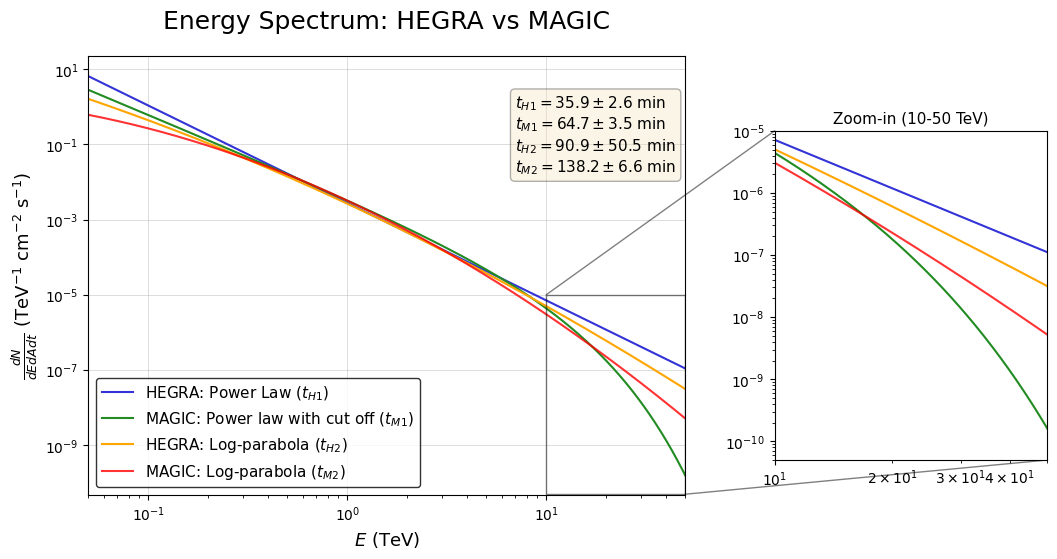

In [16]:
E = np.linspace(Emin, Emax, 2**20+1)

fig, ax = plt.subplots(figsize=(7.7, 5.7))

ax.plot(E, 1e8 * dJ_H(E, (c1 * 1e-4), alpha1), color='mediumblue', alpha=0.8, label='HEGRA: Power Law ($t_{H1}$)')
ax.plot(E, 1e8 * dJ1_MC_M(E, f0, alpha, Ec), color='forestgreen', label='MAGIC: Power law with cut off ($t_{M1}$)')
ax.plot(E, 1e8 * dJ_MC_H(E, (c2 * 1e-4), alpha2, beta), color='orange', label='HEGRA: Log-parabola ($t_{H2}$)')
ax.plot(E, 1e8 * dJ2_MC_M(E, f02, alpha2, beta2), color='red', alpha=0.8, label='MAGIC: Log-parabola ($t_{M2}$)')
ax.semilogx()
ax.semilogy()
ax.set_xlim([Emin, Emax])
ax.set_xlabel(r'$E$ (TeV)', fontsize=13)
ax.set_ylabel(r'$\frac{dN}{dE dA dt}$ (TeV$^{-1}$ cm$^{-2}$ s$^{-1}$)', fontsize=13)
ax.set_title('Energy Spectrum: HEGRA vs MAGIC', fontsize=18, pad=20)
ax.legend(loc='lower left', fontsize=11, frameon=True, edgecolor='black')
ax.grid(True, linestyle='-', linewidth=0.6, alpha=0.5)

#Zoom-in
x1, x2, y1, y2 = 1e1, 5e1, 5e-11, 1e-5

axins = ax.inset_axes([1.15, 0.08, 0.457, 0.75])
axins.plot(E, 1e8 * dJ_H(E, (c1 * 1e-4), alpha1), color='mediumblue', alpha=0.8)
axins.plot(E, 1e8 * dJ_MC_H(E, (c2 * 1e-4), alpha2, beta), color='orange')
axins.plot(E, 1e8 * dJ1_MC_M(E, f0, alpha, Ec), color='forestgreen')
axins.plot(E, 1e8 * dJ2_MC_M(E, f02, alpha2, beta2), color='red', alpha=0.8)
axins.semilogx()
axins.semilogy()
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_title('Zoom-in (10-50 TeV)', fontsize=11)

ax.indicate_inset_zoom(axins, edgecolor="black")

#Results
textstr = (
    r'$t_{H1} = %.1f \pm %.1f$ min' % (t1_H, sigma_t1_H) + '\n' +
    r'$t_{M1} = %.1f \pm %.1f$ min' % (t1_Simp_M, sigma_t1_Simp_M) + '\n' +
    r'$t_{H2} = %.1f \pm %.1f$ min' % (t2_Simp_H, sigma_t2_Simp_H) + '\n' +
    r'$t_{M2} = %.1f \pm %.1f$ min' % (t2_Simp_M, sigma_t2_Simp_M)
)

props = dict(boxstyle='round', facecolor='wheat', alpha=0.3)
ax.text(0.715, 0.915, textstr, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', bbox=props)

plt.show()

We can see that the log-parabola fit of MAGIC indicate a spectral curvature that HEGRA could not detect due to lower sensitivity.
<br> For both spectral models (power law and log-parabola), MAGIC requires longer observation times than HEGRA ($ t_{M1} > t_{H1} $, $t_{M2} > t_{H2}$). This is expected because MAGIC’s spectral fits are steeper (i.e. the flux decreases faster with energy) at high energies compared to HEGRA. Hence this means that detecting the same number of photons requires more observation time because fewer high-energy photons are detected.
<br> In particular, the MAGIC power law with a cut off further increases observation time compared to a simple HEGRA power law because the flux drops exponentially at high energies.